In [1]:
!pip install tensorflow transformers matplotlib scikit-learn


^C


     ---------------------------------------- 0.0/44.4 kB ? eta -:--:--
     --------- ------------------------------ 10.2/44.4 kB ? eta -:--:--
     ----------------- -------------------- 20.5/44.4 kB 217.9 kB/s eta 0:00:01
     ----------------------------------- -- 41.0/44.4 kB 330.3 kB/s eta 0:00:01
     -------------------------------------- 44.4/44.4 kB 313.3 kB/s eta 0:00:00
     ---------------------------------------- 0.0/59.7 kB ? eta -:--:--
     ---------------------------------------- 59.7/59.7 kB 1.5 MB/s eta 0:00:00
  Using cached filelock-3.17.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached PyYAML-6.0.2-cp311-cp311-win_amd64.whl.metadata (2.1 kB)
  Using cached regex-2024.11.6-cp311-cp311-win_amd64.whl.metadata (41 kB)
  Using cached tokenizers-0.21.0-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.5.2-cp38-abi3-win_amd64.whl.metadata (3.9 kB)
     ---------------------------------------- 0.0/48.6 kB ? eta -:--:--
     ------------------------

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\HP\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\tensorflow\\include\\external\\com_github_grpc_grpc\\src\\core\\ext\\filters\\client_channel\\lb_policy\\grpclb\\client_load_reporting_filter.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths


[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: C:\Users\HP\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Dense, Dropout, LayerNormalization, 
    GlobalAveragePooling1D, Reshape, MultiHeadAttention
)
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Load the preprocessed AST features
with open("ast_features.pkl", "rb") as f:
    ast_features, labels = pickle.load(f)

# Convert labels to categorical
num_classes = len(np.unique(labels))
labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(ast_features, labels, test_size=0.2, random_state=42)

# Ensure correct input shape (batch_size, 128, 500, 1)
X_train = np.expand_dims(X_train, axis=-1)  
X_test = np.expand_dims(X_test, axis=-1)

# Define AST Transformer Model
def create_ast_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)  # (128, 500, 1)

    # **FIX: Keep Spectrogram Shape Intact**
    x = Reshape((128, 500))(inputs)  # (batch_size, 128, 500)

    # Patch Embedding (Reduced Hidden Units)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = LayerNormalization()(x)

    # **Reduced Transformer Complexity**
    for _ in range(2):  # Reduced from 4 to 2 blocks
        attn_output = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)  # Reduced heads from 8 to 4, key_dim from 64 to 32
        x = LayerNormalization()(x + attn_output)
        
        ffn_output = Dense(256, activation="relu")(x)  # Reduced Dense size from 512 to 256
        x = LayerNormalization()(x + ffn_output)

    # **Corrected Global Average Pooling**
    x = GlobalAveragePooling1D()(x)  

    # Classification Head
    x = Dense(128, activation="relu")(x)  # Reduced Dense size from 256 to 128
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    # Build and Compile Model
    model = keras.Model(inputs, outputs)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=AdamW(learning_rate=0.001),
        metrics=["accuracy"]
    )
    return model

# Create and Train Model
input_shape = X_train.shape[1:]  
model = create_ast_model(input_shape, num_classes)

# Train Model with Reduced Batch Size
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Save Trained Model
model.save("ast_transformer_model_optimized.h5")

# Evaluate Model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print Classification Metrics
print("Test Accuracy:", accuracy_score(y_test_classes, y_pred_classes))
print(classification_report(y_test_classes, y_pred_classes))





Epoch 1/10


219/219 [==============================] - 95s 399ms/step - loss: 2.3050 - accuracy: 0.1112 - val_loss: 2.2581 - val_accuracy: 0.1151
Epoch 2/10
219/219 [==============================] - 96s 438ms/step - loss: 2.2677 - accuracy: 0.1170 - val_loss: 2.2594 - val_accuracy: 0.1048
Epoch 3/10
219/219 [==============================] - 95s 436ms/step - loss: 2.2664 - accuracy: 0.1095 - val_loss: 2.2598 - val_accuracy: 0.1048
Epoch 4/10
219/219 [==============================] - 95s 435ms/step - loss: 2.2542 - accuracy: 0.1194 - val_loss: 2.2124 - val_accuracy: 0.1820
Epoch 5/10
219/219 [==============================] - 97s 442ms/step - loss: 2.1266 - accuracy: 0.1797 - val_loss: 2.0764 - val_accuracy: 0.2221
Epoch 6/10
219/219 [==============================] - 98s 446ms/step - loss: 2.0882 - accuracy: 0.1953 - val_loss: 2.0792 - val_accuracy: 0.2210
Epoch 7/10
219/219 [==============================] - 96s 437ms/step - loss: 2.0711 - accuracy: 0.2033 - val_loss: 2.0180 - v

C:\Users\Manoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/55 [==============================] - 10s 158ms/step
Test Accuracy: 0.22438465941614197
              precision    recall  f1-score   support

           0       0.25      0.48      0.33       203
           1       0.00      0.00      0.00        86
           2       0.17      0.49      0.25       183
           3       0.16      0.40      0.23       201
           4       0.33      0.32      0.32       206
           5       0.49      0.25      0.34       193
           6       0.00      0.00      0.00        72
           7       0.00      0.00      0.00       208
           8       0.00      0.00      0.00       165
           9       0.32      0.05      0.08       230

    accuracy                           0.22      1747
   macro avg       0.17      0.20      0.16      1747
weighted avg       0.20      0.22      0.18      1747



C:\Users\Manoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Manoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Manoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

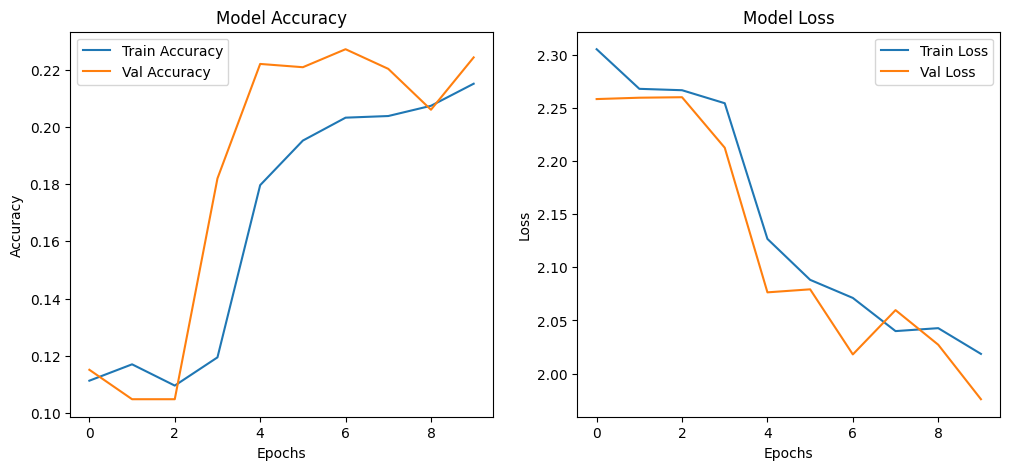

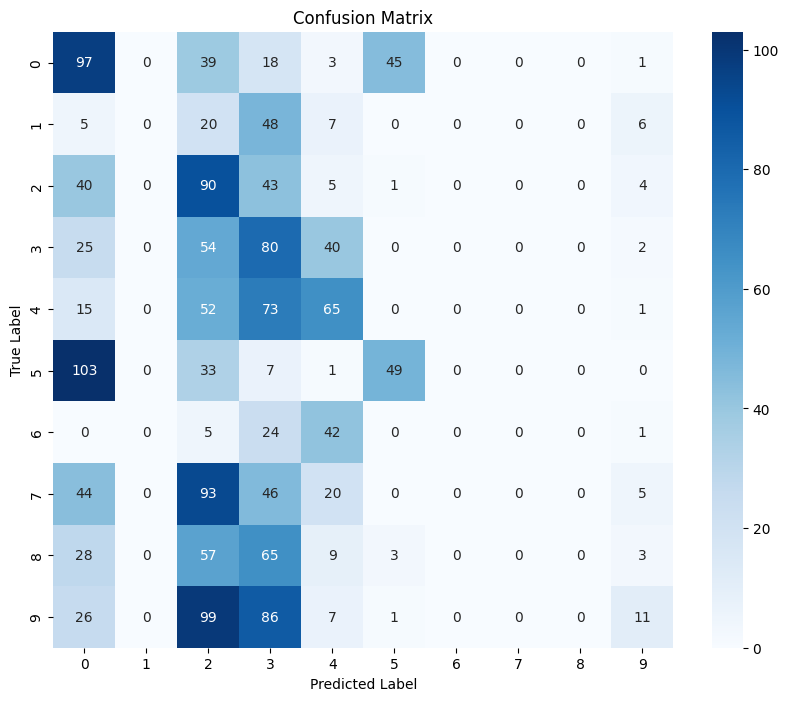

C:\Users\Manoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Manoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Manoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

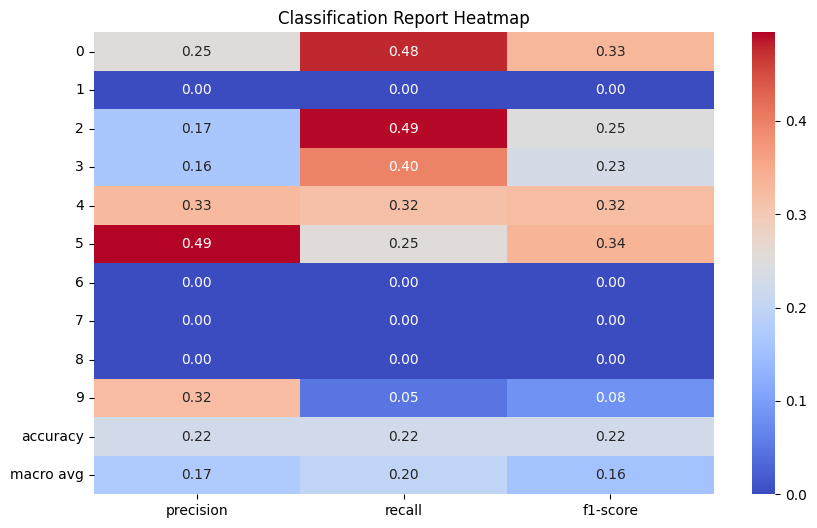

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Plot Training Accuracy and Loss
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # Accuracy Plot
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    ax[0].set_title("Model Accuracy")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend()
    
    # Loss Plot
    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Val Loss')
    ax[1].set_title("Model Loss")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].legend()
    
    plt.show()

# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Plot Classification Report Heatmap
def plot_classification_report(y_true, y_pred, classes):
    from sklearn.metrics import classification_report
    report = classification_report(y_true, y_pred, output_dict=True)
    
    # Convert report to DataFrame
    report_df = pd.DataFrame(report).transpose().iloc[:-1, :-1]  # Remove support column
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Classification Report Heatmap")
    plt.show()

# Plot results
plot_training_history(history)
plot_confusion_matrix(y_test_classes, y_pred_classes, classes=np.arange(num_classes))
plot_classification_report(y_test_classes, y_pred_classes, classes=np.arange(num_classes))
